In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import cv2
import sys
sys.path.append("..")

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [2]:
sam_checkpoint = "/kaggle/input/segment-anything-models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=120,  # Requires open-cv to run post-processing
)

predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


# show_anns

In [3]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)))

# show_points

In [4]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='red', marker='o', s=80, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o', s=80, edgecolor='white', linewidth=1.25)

# show_mask

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=1)
    else:
        color = np.array([200/255, 0/255, 0/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# custom_plot

In [6]:
def custom_plot(title,image,specific_point):
    input_label = np.array([1])
    
    masks = mask_generator_2.generate(image)
    
    predictor.set_image(image)
    masks_p, scores, logits = predictor.predict(
    point_coords=specific_point,
    point_labels=input_label,
    multimask_output=True,)
    
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(13,5))
    fig.suptitle(f'{title} tumor')
    plt.axis('off')
    ax1.imshow(image)
    ax1.title.set_text("Image")
    ax2.imshow(image)
    ax2.title.set_text("Image+Masks")
    show_anns(masks, ax2)
    for i, (mask, score) in enumerate(zip(masks_p, scores)):
        if i==0:
            ax3.imshow(image)
            ax3.title.set_text("a specific object")
            show_points(specific_point, input_label, ax3)
            show_mask(mask, ax4)
            ax4.title.set_text(f"Mask - Score: {score:.3f}")
    for ax in fig.get_axes():
        ax.label_outer()
        ax.axis('off')

# load_images_from_folder

In [7]:
Brain_path = "/kaggle/input/sam-images/Tumor/Brain"
Kidney_path = "/kaggle/input/sam-images/Tumor/Kidney"
Liver_path = "/kaggle/input/sam-images/Tumor/Liver"
Lung_path = "/kaggle/input/sam-images/Tumor/Lung"


Brain = []
Kidney = []
Liver = []
Lung = []


def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            image = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)  
            images.append(image)
    return images

Brain = load_images_from_folder(Brain_path)
Kidney = load_images_from_folder(Kidney_path)
Liver = load_images_from_folder(Liver_path)
Lung = load_images_from_folder(Lung_path)


print(f"Loaded {len(Brain)} Brain images")
print(f"Loaded {len(Kidney)} Kidney images")
print(f"Loaded {len(Liver)} Liver images")
print(f"Loaded {len(Lung)} Lung images")

Loaded 4 Brain images
Loaded 4 Kidney images
Loaded 3 Liver images
Loaded 2 Lung images


# display_images_with_masks

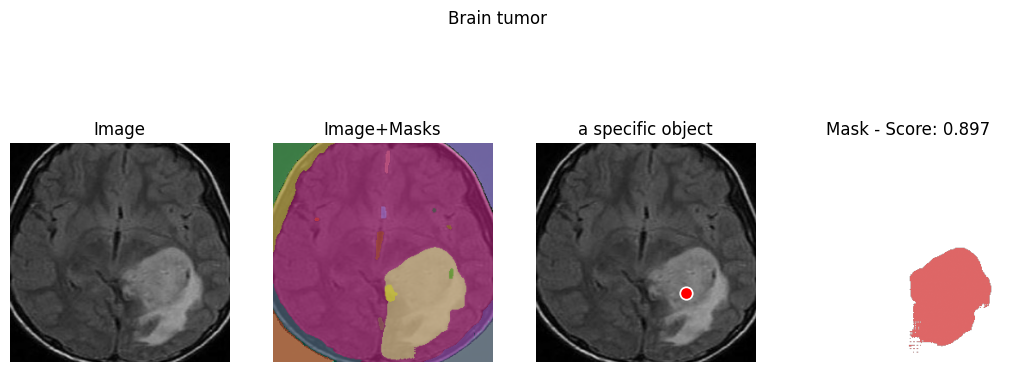

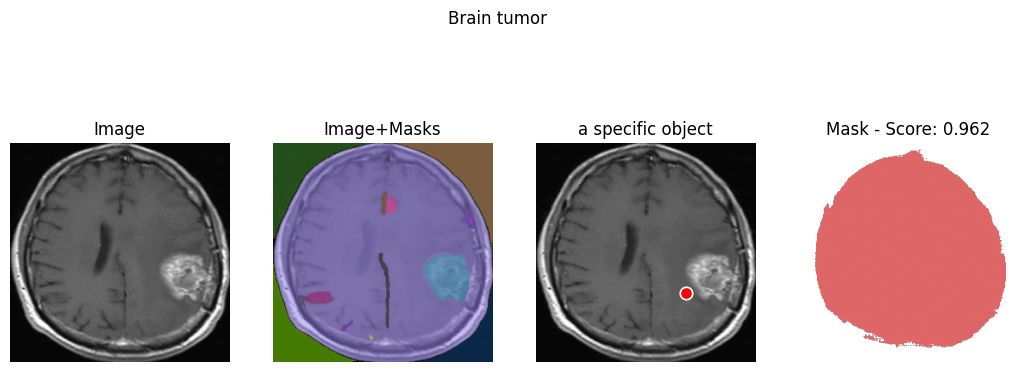

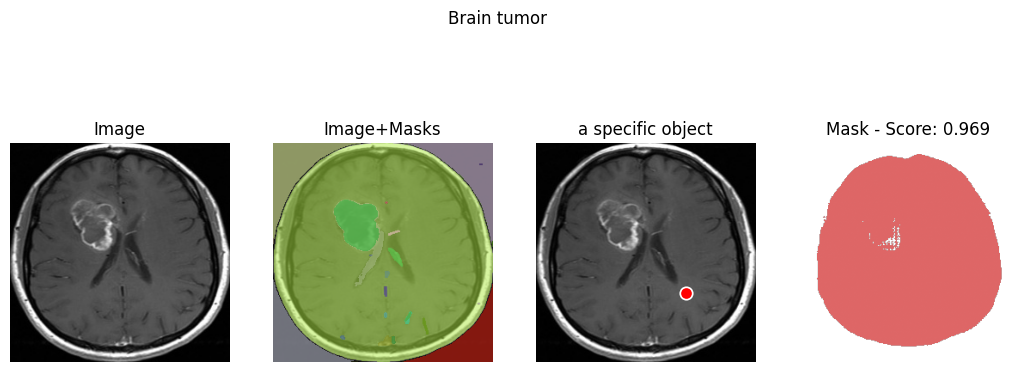

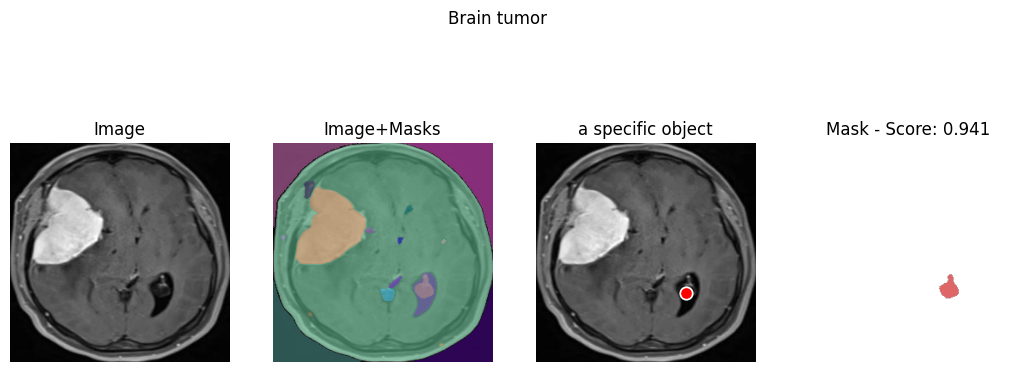

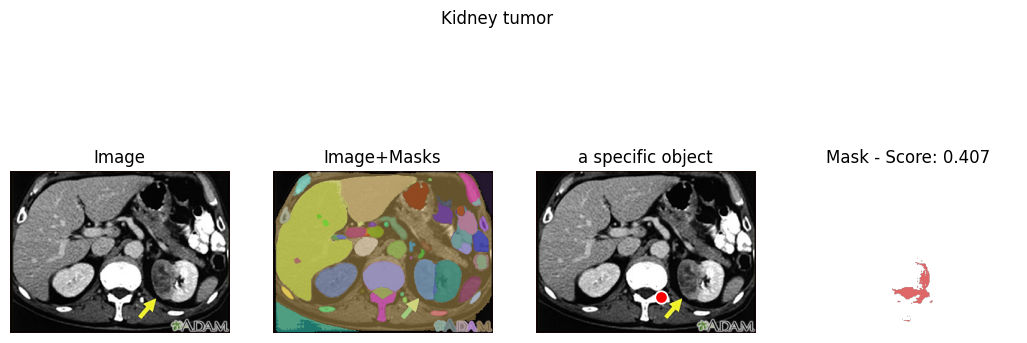

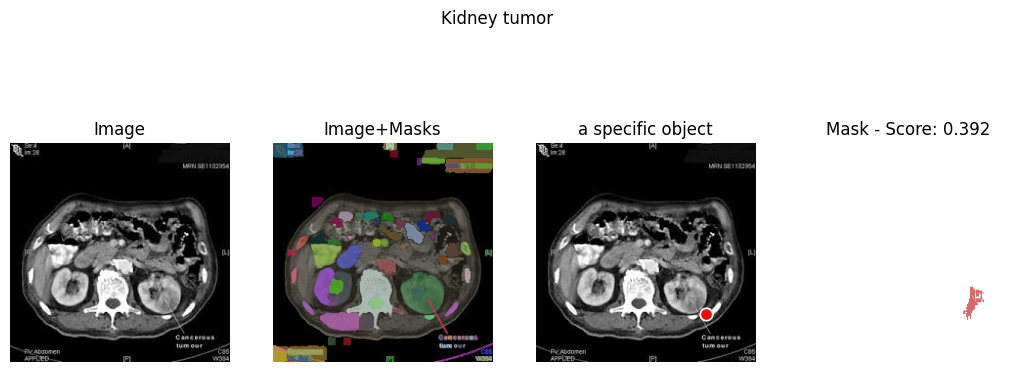

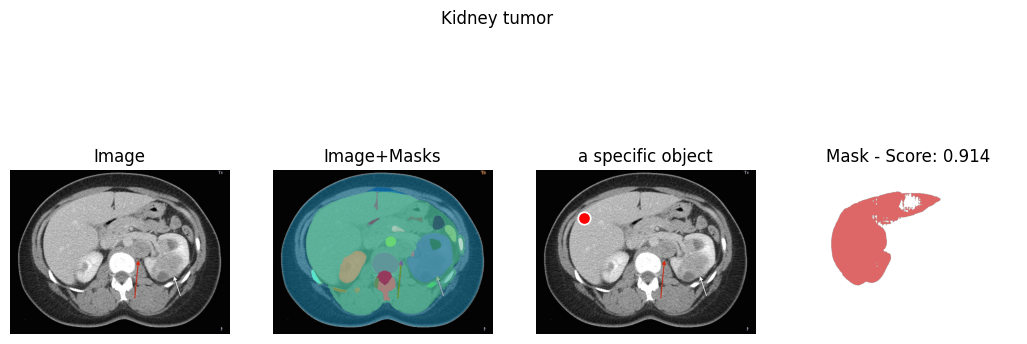

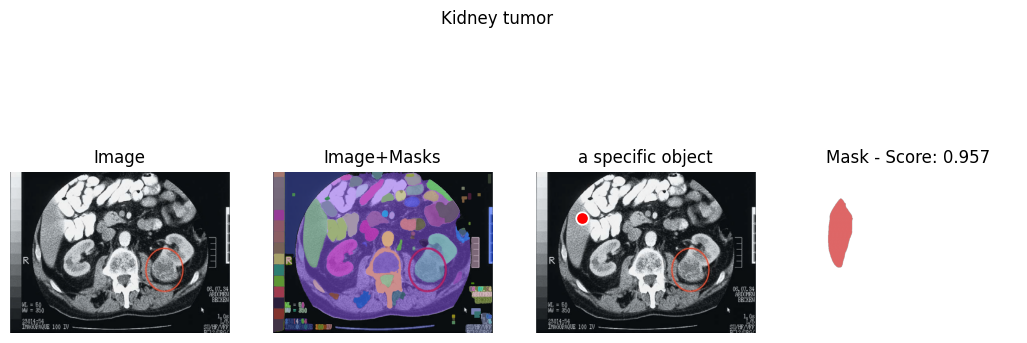

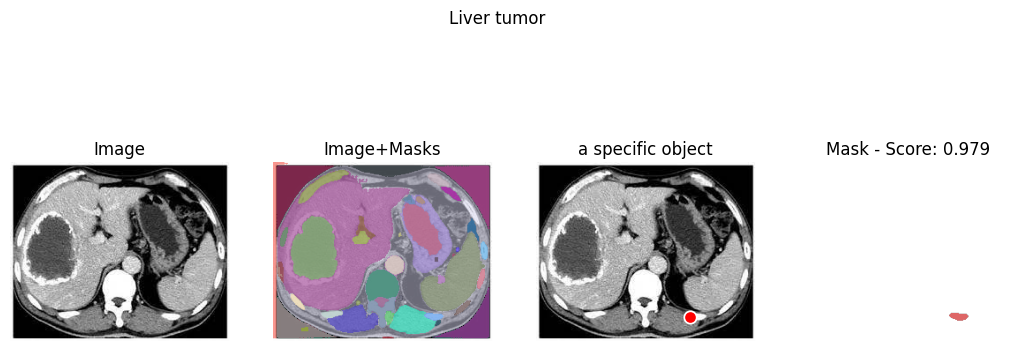

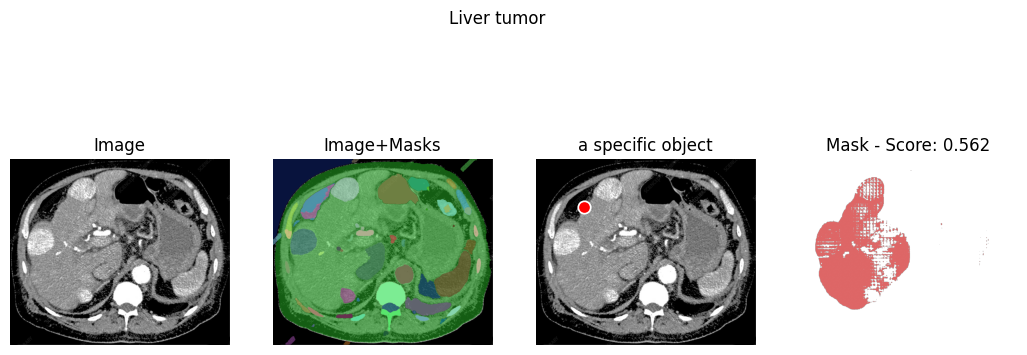

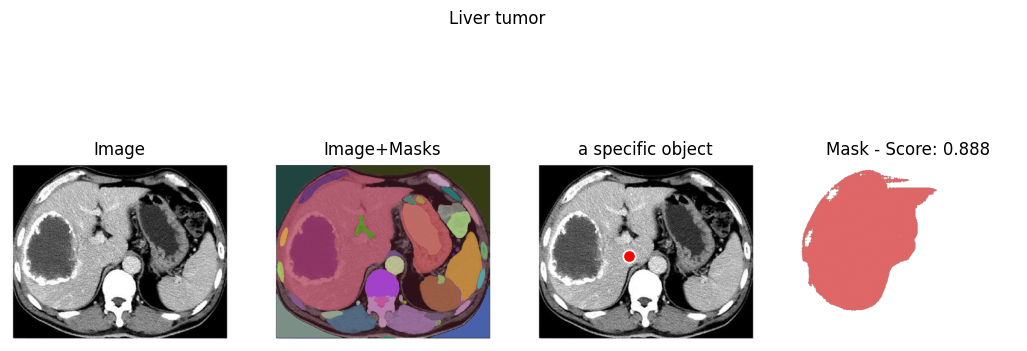

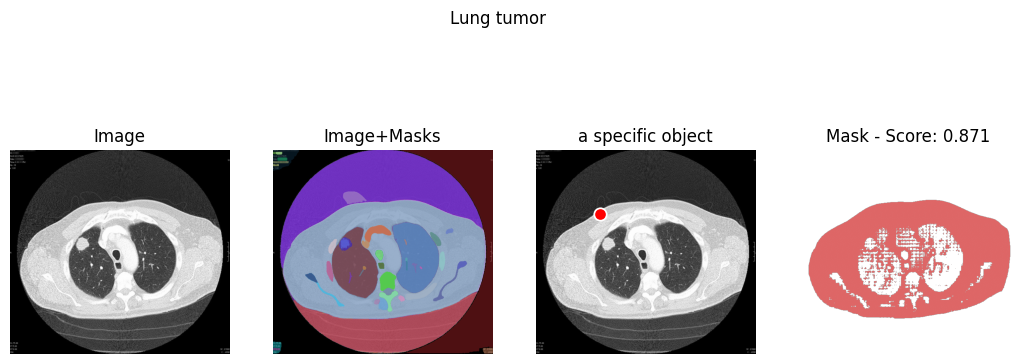

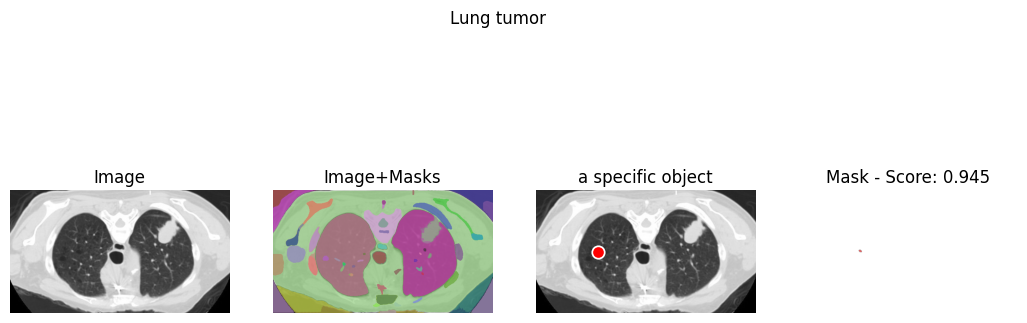

In [8]:
specific_point = np.array([[175, 175]])

def display_images_with_masks():
    for images, title in zip([Brain, Kidney, Liver, Lung], ["Brain", "Kidney", "Liver", "Lung"]):
        for image in images:
            custom_plot(title, image, specific_point)

display_images_with_masks()
